# Saliency

We adapt the [useless neurons query](./2%20Querying%20useless%20neurons.ipynb)
to instead calculate the *saliency*. That is, for a given input, we calculate
how much each individual input node contributes to the end result. We'll start
with a basic example, and then we apply the query to an image classifier.

## Basic example

We start with a small function with 10 inputs. The function we are trying to
learn returns the sum, but only of the inputs with an odd index. This
should, theoretically, result in the even-indexed inputs to not contribute anything.

In [2]:
import torch
import numpy as np
import utils.duckdb as db
import utils.nn as nn
import os
import itertools

torch.manual_seed(223)

def f(*args):
    """
    Returns the sum of the arguments passed to this, but only looking at
    arguments with an odd index.
    """
    return sum([x for (i, x) in enumerate(args) if i % 2 == 1])

model = nn.ReLUFNN(
    input_size=10,
    output_size=1,
    hidden_size=100,
    num_hidden_layers=5
)

num_samples = 10000
x_train = torch.randn(num_samples, 10) * 100
y_train = [[f(*xs)] for xs in x_train]

nn.train(model, x_train, y_train, epochs=15, save_path="models/saliency_nn.pt")

db.load_pytorch_model_into_db(model)
db.con.execute("EXPORT DATABASE 'dbs/saliency.db'")


Let's see if our model performs as expected.

In [3]:
model.eval()

example_inputs = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], # Should return 5
    [1, 5, 1, -5, 1, 5, 1, -5, 1, 5], # Should return 5
    [1, 2, 3, 4, 5, 6, 7, 8, 9 ,10], # Should return 30
    [1, 10, 2, 20, 3, 30, 4, 40, 5, 50], # Should return 150
]

with torch.no_grad():
    result = model(torch.tensor(example_inputs, dtype=torch.float32))
    print(result)

tensor([[  3.9809],
        [  4.8332],
        [ 22.5017],
        [110.3929]])


The results of our network are not perfect, but good enough for our purposes.
Before we move on to the saliency query, let's do a quick sanity check and
see if an `eval` on the model in our database returns the same results.

In [4]:
with open('queries/eval_recursive_from_input_optim.sql') as file:
    eval_query = file.read()

db.con.sql("TRUNCATE TABLE input")
for input_set_id, input in enumerate(example_inputs):
    input_node_idx = 1
    for x in input:
        db.con.sql(f"""
            INSERT INTO input (input_set_id, input_node_idx, input_value)
            VALUES ({input_set_id}, {input_node_idx}, {x})
        """)
        input_node_idx += 1

    db.con.sql("EXPORT DATABASE 'dbs/test.db';")

db.con.sql(eval_query)


┌──────────────┬────────────────────┬───────┐
│ input_set_id │       value        │  id   │
│    int32     │       double       │ int32 │
├──────────────┼────────────────────┼───────┤
│            0 │  3.980904496114195 │   511 │
│            1 │  4.833184254184151 │   511 │
│            2 │ 22.501725645422987 │   511 │
│            3 │ 110.39291306779965 │   511 │
└──────────────┴────────────────────┴───────┘

Looks good, so let's move on!

## The saliency query

We first delete everything but the first input set, to make things more clear.

In [5]:
db.con.sql("DELETE FROM input WHERE input_set_id <> 0")

The saliency query can be found [here](./queries/saliency.sql). It is almost the
same as the useless neuron overview query, except we iterate over the input
nodes instead of the hidden nodes.

In [6]:
with open('queries/saliency.sql') as file:
    saliency_query = file.read()

result = db.con.sql(saliency_query)
result


┌──────────────┬─────────────┬───────────┬──────────────────────┐
│ input_set_id │ i_to_remove │ output_id │       saliency       │
│    int32     │    int32    │   int32   │        double        │
├──────────────┼─────────────┼───────────┼──────────────────────┤
│            0 │           1 │       511 │   0.1600594652605496 │
│            0 │           2 │       511 │   0.6701696022449539 │
│            0 │           3 │       511 │  0.10351041003985761 │
│            0 │           4 │       511 │   0.7613947272728097 │
│            0 │           5 │       511 │  0.02848658866034892 │
│            0 │           6 │       511 │   0.7362538524272311 │
│            0 │           7 │       511 │ 0.009439831667148457 │
│            0 │           8 │       511 │   0.7190573414185222 │
│            0 │           9 │       511 │  0.01805737739097868 │
│            0 │          10 │       511 │   0.5808162395130965 │
├──────────────┴─────────────┴───────────┴──────────────────────┤
│ 10 rows 

If we plot this, we can see that the odd input neurons are more important than
the even ones, as expected.

<Axes: >

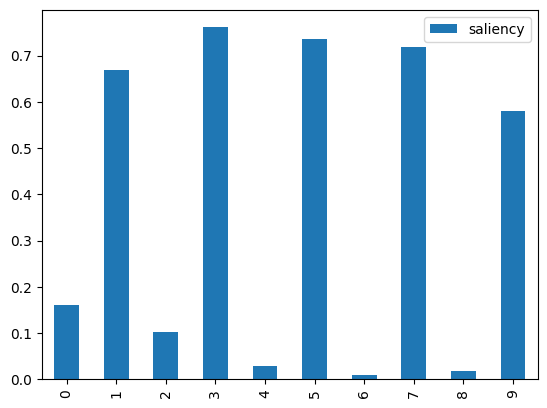

In [7]:
result.df().plot.bar(y='saliency')

## Saliency for an image classification model

Now let's move to a more real-world example: saliency for an image
classification model. For this, we'll reuse [the CNN
example](/1.8%20Eval%20-%20CNN.ipynb). This assumes you have run that notebook
before, so `mnist_cnn.pt` and `eval_cnn.db` are available.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64 // 4, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net()
model.load_state_dict(torch.load('models/mnist_cnn.pt', weights_only=True))
model.eval()

db.reconnect()
db.con.execute(f"IMPORT DATABASE 'dbs/eval_cnn.db'")

Now let's pick a test image from the MNIST dataset.

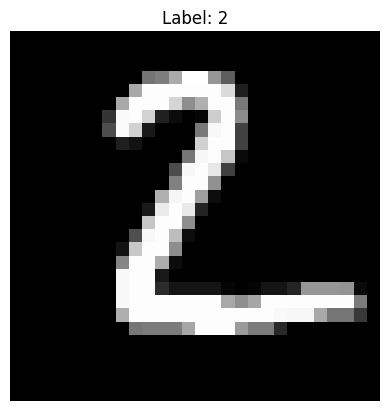

In [9]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

dataset = datasets.MNIST('../data', train=False)
image, label = dataset[1]

image = transforms.ToTensor()(image)
image_np = image.squeeze().numpy()

plt.imshow(image_np, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')  # Turn off axis
plt.show()

Apply the transformation to it for future steps:

In [10]:
image = (image - 0.1307) / 0.3081
image_np = (image_np - 0.1307) / 0.3081

And calculate the saliency for it:

In [11]:
def load_image_into_input_table(image):
    db.con.execute("TRUNCATE input")
    for i, pixel in enumerate(image.flatten()):
        db.con.execute("""
            INSERT INTO input (input_set_id, input_node_idx, input_value)
            VALUES (0, $input_node_idx, $input_value)
        """,
        {'input_node_idx': i + 1, 'input_value': pixel.item()})
    db.con.sql("EXPORT DATABASE 'dbs/eval_cnn_w_input.db'")

load_image_into_input_table(image)
#db.con.sql(saliency_query)

This query takes 3+ minutes on a decent machine, but needs a lot of available
RAM to prevent DuckDB from swapping and slowing down hard (with 16GB total RAM
we have a bit of swapping, causing the 3+ minutes). In any case, the scaling is
not great.

## Alternative approach: evals in a loop

We will instead do evals in a loop, since this is faster than a single saliency
query.

In [12]:
query = """
WITH RECURSIVE input_values AS (
    -- Fetch input values from an existing table
    SELECT input_set_id, input_node_idx, input_value FROM input
),
input_nodes AS (
    SELECT
        id,
        bias,
        ROW_NUMBER() OVER (ORDER BY id) AS input_node_idx
    FROM node n
    -- NOT EXISTS is faster
    WHERE NOT EXISTS
        (SELECT 1 FROM edge WHERE dst = n.id)
),
output_nodes AS (
    SELECT id, bias
    FROM node n
    -- NOT EXISTS is faster
    WHERE NOT EXISTS
    (SELECT 1 FROM edge WHERE src=n.id)
),
tx AS (
    -- Base case (t1)
    SELECT
        v.input_set_id AS input_set_id,
        GREATEST(0, n.bias + SUM(e.weight * v.input_value)) AS value,
        e.dst AS id,
    -- JOIN order matters for performance!
    FROM input_nodes i
    JOIN input_values v ON i.input_node_idx = v.input_node_idx
    JOIN edge e ON i.id = e.src
    JOIN node n ON e.dst = n.id
    WHERE i.input_node_idx <> ?
    GROUP BY e.dst, n.bias, v.input_set_id

    UNION ALL

    -- Recursive case
    SELECT
        tx.input_set_id AS input_set_id,
        GREATEST(0, n.bias + SUM(e.weight * tx.value)) AS value,
        e.dst AS id,
    FROM tx
    JOIN edge e ON tx.id = e.src
    JOIN node n ON e.dst = n.id
    GROUP BY e.dst, n.bias, tx.input_set_id
),
-- As the last step, repeat the calculation for the output nodes, but omit the
-- ReLU this time (per definition)
t_out AS (
    SELECT
        tx.input_set_id AS input_set_id,
        o.bias + SUM(e.weight * tx.value) AS value,
        e.dst AS id
    FROM output_nodes o
    JOIN edge e ON e.dst = o.id
    JOIN tx ON tx.id = e.src
    GROUP BY e.dst, o.bias, tx.input_set_id
)
SELECT * FROM t_out ORDER BY input_set_id, id;
"""


In [13]:
import concurrent.futures

def fetch_data(i):
    return db.con.execute(query, [i]).fetchall()

# It's about 50% faster to do in parallel.
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(fetch_data, range(1, 28*28 + 1)))

In [14]:
with open('queries/eval_recursive_from_input_optim.sql') as file:
    eval_query = file.read()

actual_result = db.con.execute(eval_query).fetchall()
actual_result

[(0, -10.184259133986917, 31761),
 (0, -9.052014955936402, 31762),
 (0, 5.659585574770499, 31763),
 (0, -18.47681388284572, 31764),
 (0, -16.05940162041364, 31765),
 (0, -24.80347757614684, 31766),
 (0, -10.41162697276949, 31767),
 (0, -18.65623944292892, 31768),
 (0, -17.674924512046424, 31769),
 (0, -25.615674505490393, 31770)]

In [15]:
diffs = []

max_actual_sql = max([row[1] for row in actual_result])
guessed_digit = max(range(len(actual_result)), key=lambda i: actual_result[i][1])

for result in results:
    # There are several ways to calculate saliency for multiple output nodes.
    # This just compares the results of the guessed digits. Other options could
    # be to take the average difference across all output nodes.
    sal_result = result[guessed_digit][1]
    diffs.append(abs(sal_result - max_actual_sql))

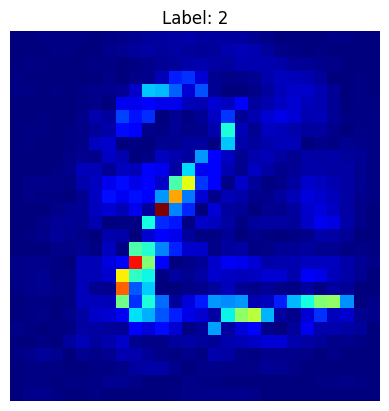

In [16]:
plt.imshow(np.array(diffs).reshape(image_np.shape), cmap='jet')
plt.axis('off')
plt.title(f"Label: {label}")
plt.show()

We now do the same in PyTorch, to see how the results compare.

/tmp/ipykernel_7498/2420686613.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  result = model(torch.tensor([np.array(img)], dtype=torch.float32))


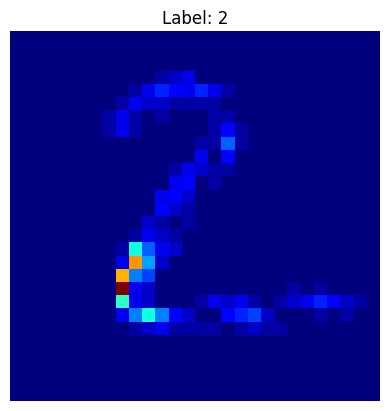

In [17]:
results = []
for i in range(0, 28*28):
    img = np.copy(image_np).flatten()
    img[i] = (0 - 0.1307) / 0.3081
    img = img.reshape(1, 28, 28)
    result = model(torch.tensor([np.array(img)], dtype=torch.float32))
    results.append(result)

og_result = model(image.unsqueeze(0))

diffs = []

max_actual = max([x.item() for x in og_result[0]])
for result in results:
    max_result = max([x.item() for x in result[0]])
    diffs.append(abs(max_result - max_actual))

plt.imshow(np.array(diffs).reshape(image_np.shape), cmap='jet')
plt.axis('off')
plt.title(f"Label: {label}")
plt.show()

## Another alternative: multiple input sets

Our `eval` query supports evaluating multiple input sets at once. We'll try to
create an input set for each pixel, each time with that pixel missing from it.

In [18]:
def input_generator():
    for input_set_id in range(0, 28*28):
        img = np.copy(image_np).flatten()
        img[input_set_id] = (0 - 0.1307) / 0.3081

        for input_node_idx, pixel in enumerate(img):
            yield [input_set_id, input_node_idx + 1, pixel]

db.con.execute("TRUNCATE input")
db.batch_insert(input_generator(), 'input')

In [ ]:
#results = db.con.execute(eval_query).fetchall()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

 This takes a while (~1m on 16GB RAM, 16 CPU machine), but we do get our
 results. We now have to massage this in python to get the saliency image.

In [23]:
%%script echo "skip"

diffs = []
max_actual = max([x.item() for x in og_result[0]])

for k,g in itertools.groupby(results, lambda x: x[0]):
    values = map(lambda x: x[1], g)
    max_value = max(values)
    diffs.append(abs(max_value - max_actual_sql))

plt.imshow(np.array(diffs).reshape(image_np.shape), cmap='jet')
plt.axis('off')
plt.title(f"Label: {label}")
plt.show()

skip


## Input weights

Does it make sense to look only at the input weights of the input edges instead?
This would be a "generic saliency", not for a single input. Let's try it.

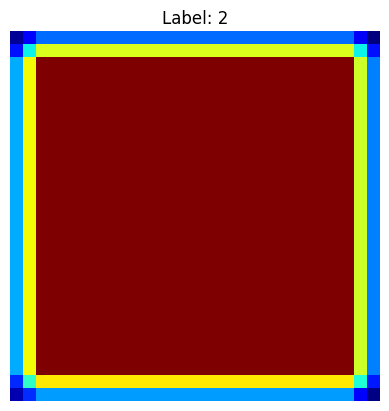

In [21]:
with open('queries/saliency_input_weights.sql') as file:
    query = file.read()

df = db.con.execute(query).df()
plt.imshow(np.array(df['weighted_weight']).reshape(image_np.shape), cmap='jet')
plt.axis('off')
plt.title(f"Label: {label}")
plt.show()

Conclusion: it does not make sense. This simply shows how we constructed the
convolutions using an extra hidden layer.

TODO: test on the first linear layer instead. Is this feasible, with the convolutions?

Let's instead look at our first example and see what the weights tell us there.

<Axes: >

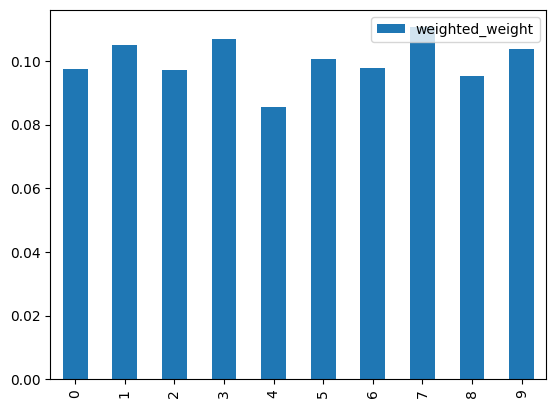

In [22]:
with open('queries/saliency_input_weights.sql') as file:
    query = file.read()

db.reconnect()
db.con.execute("IMPORT DATABASE 'dbs/saliency.db'")
df = db.con.execute(query).df()
df.plot.bar(y='weighted_weight')

We can still see that the odd values contribute more to the output, as expected,
though the effect is much less pronounced. I believe we can conclude that
looking at the input weights alone is not a good approximation for saliency.